## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution with spatial dimension included

### training on each image separately

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [8]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [9]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model(nwaves):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(50), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(50), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)
    Dense_1 = layers.Dense(512, activation="relu")(Flatten_1)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1],
                        outputs=[Output],)
    
    return model

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['accuracy'])
    ax2.plot(model.history['val_accuracy'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['accuracy'])
    ax4.plot(model.history['val_accuracy'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


---
## CNN trained on veg_00000 (Scene 1-b South Facing @ ~6pm)

In [12]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [13]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [14]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


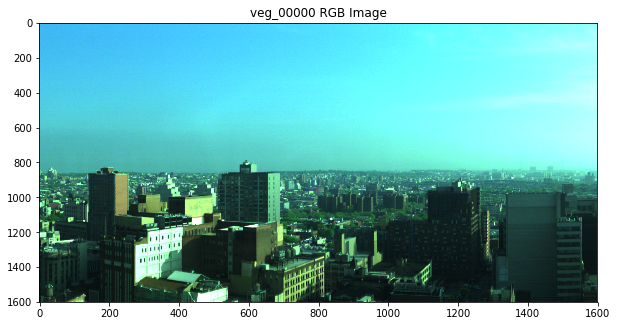

In [15]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

In [15]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
print(cube_standard0.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [13]:
sky_coords0 = read_labelled_coordinates("1_sky", "000")
clouds_coords0 = read_labelled_coordinates("2_clouds", "000")
veg_coords0 = read_labelled_coordinates("3_vegetation", "000")
wtr_coords0 = read_labelled_coordinates("4_water", "000")
blt_coords0 = read_labelled_coordinates("5_buildings", "000")
windows_coords0 = read_labelled_coordinates("6_windows", "000")
rds_coords0 = read_labelled_coordinates("7_roads", "000")
cars_coords0 = read_labelled_coordinates("8_cars", "000")
mtl_coords0 = read_labelled_coordinates("9_metal", "000")

1_sky: (400, 2)
2_clouds: (500, 2)
3_vegetation: (610, 2)
4_water: (0,)
5_buildings: (1200, 2)
6_windows: (500, 2)
7_roads: (60, 2)
8_cars: (55, 2)
9_metal: (230, 2)


#### split classified pixels into 80% training and 20% testing sets

In [14]:
trrat = 0.8
sky_train_ind0, sky_test_ind0 = split_train_test_indices(sky_coords0, 10, trrat, "sky")
clouds_train_ind0, clouds_test_ind0 = split_train_test_indices(clouds_coords0, 20, trrat, "clouds")
veg_train_ind0, veg_test_ind0 = split_train_test_indices(veg_coords0, 30, trrat, "veg")
#wtr_train_ind0, wtr_test_ind0 = split_train_test_indices(wtr_coords0, 40, trrat, "wtr")
blt_train_ind0, blt_test_ind0 = split_train_test_indices(blt_coords0, 50, trrat, "blt")
windows_train_ind0, windows_test_ind0 = split_train_test_indices(windows_coords0, 60, trrat, "windows")
rds_train_ind0, rds_test_ind0 = split_train_test_indices(rds_coords0, 70, trrat, "rds")
cars_train_ind0, cars_test_ind0 = split_train_test_indices(cars_coords0, 80, trrat, "cars")
mtl_train_ind0, mtl_test_ind0 = split_train_test_indices(mtl_coords0, 90, trrat, "mtl")

sky: 320 80
clouds: 400 100
veg: 488 122
blt: 960 240
windows: 400 100
rds: 48 12
cars: 44 11
mtl: 184 46


In [18]:
cube_std0_3d = cube_standard0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
print(cube_std0_3d.shape)

(1600, 1600, 848)


In [19]:
cube_sky_train0 = cube_std0_3d[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
cube_sky_test0 = cube_std0_3d[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
print("sky ", cube_sky_train0.shape, cube_sky_test0.shape)

cube_clouds_train0 = cube_std0_3d[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
cube_clouds_test0 = cube_std0_3d[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
print("clouds ", cube_clouds_train0.shape, cube_clouds_test0.shape)

cube_veg_train0 = cube_std0_3d[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
cube_veg_test0 = cube_std0_3d[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
print("vegetation ", cube_veg_train0.shape, cube_veg_test0.shape)

#cube_wtr_train0 = cube_std0_3d[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#cube_wtr_test0 = cube_std0_3d[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#print("water ", cube_wtr_train0.shape, cube_wtr_test0.shape)

cube_blt_train0 = cube_std0_3d[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
cube_blt_test0 = cube_std0_3d[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
print("built ", cube_blt_train0.shape, cube_blt_test0.shape)

cube_windows_train0 = cube_std0_3d[windows_coords0[windows_train_ind0[:],0], windows_coords0[windows_train_ind0[:],1],:]
cube_windows_test0 = cube_std0_3d[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
print("windows ", cube_windows_train0.shape, cube_windows_test0.shape)

cube_rds_train0 = cube_std0_3d[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
cube_rds_test0 = cube_std0_3d[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
print("roads ", cube_rds_train0.shape, cube_rds_test0.shape)

cube_cars_train0 = cube_std0_3d[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cube_cars_test0 = cube_std0_3d[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
print("cars ", cube_cars_train0.shape, cube_cars_test0.shape)

cube_mtl_train0 = cube_std0_3d[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
cube_mtl_test0 = cube_std0_3d[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
print("metal ", cube_mtl_train0.shape, cube_mtl_test0.shape)

sky  (320, 848) (80, 848)
clouds  (400, 848) (100, 848)
vegetation  (488, 848) (122, 848)
built  (960, 848) (240, 848)
windows  (400, 848) (100, 848)
roads  (48, 848) (12, 848)
cars  (44, 848) (11, 848)
metal  (184, 848) (46, 848)


In [20]:
cube_train0 = np.concatenate((cube_sky_train0, cube_clouds_train0, cube_veg_train0, cube_blt_train0,
                             cube_windows_train0, cube_rds_train0, cube_cars_train0, cube_mtl_train0), axis=0)
cube_train_labels0 = [0]*cube_sky_train0.shape[0] + [1]*cube_clouds_train0.shape[0] \
                + [2]*cube_veg_train0.shape[0] + [4]*cube_blt_train0.shape[0] \
                + [5]*cube_windows_train0.shape[0] + [6]*cube_rds_train0.shape[0] \
                + [7]*cube_cars_train0.shape[0] + [8]*cube_mtl_train0.shape[0]

cube_test0 = np.concatenate((cube_sky_test0, cube_clouds_test0, cube_veg_test0, cube_blt_test0,
                             cube_windows_test0, cube_rds_test0, cube_cars_test0, cube_mtl_test0), axis=0)
cube_test_labels0 = [0]*cube_sky_test0.shape[0] + [1]*cube_clouds_test0.shape[0] \
                + [2]*cube_veg_test0.shape[0] + [4]*cube_blt_test0.shape[0] \
                + [5]*cube_windows_test0.shape[0] + [6]*cube_rds_test0.shape[0] \
                + [7]*cube_cars_test0.shape[0] + [8]*cube_mtl_test0.shape[0]

In [21]:
cube_train_labels0 = np.array(cube_train_labels0)
cube_test_labels0 = np.array(cube_test_labels0)

print(cube_train0.shape, cube_train_labels0.shape)
print(cube_test0.shape, cube_test_labels0.shape)

(2844, 848) (2844,)
(711, 848) (711,)


### Train CNN

In [23]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [24]:
#keras.utils.plot_model(cnn0, show_shapes=True)
#cnn0.summary()

cube_train02 = cube_train0.reshape(cube_train0.shape[0], cube_train0.shape[1], 1)
cube_test02 = cube_test0.reshape(cube_test0.shape[0], cube_test0.shape[1], 1)

In [25]:
CNNmodel0 = cnn0.fit({"spectra":cube_train02}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02}, cube_test_labels0),
                     epochs=200, batch_size=512)

Epoch 1/200
6/6 [==============================] - 1s 176ms/step - loss: 2.2575 - accuracy: 0.3003 - val_loss: 1.7860 - val_accuracy: 0.3741
Epoch 2/200
6/6 [==============================] - 1s 139ms/step - loss: 1.4678 - accuracy: 0.4919 - val_loss: 1.1497 - val_accuracy: 0.6596
Epoch 3/200
6/6 [==============================] - 1s 150ms/step - loss: 0.9705 - accuracy: 0.6966 - val_loss: 0.8740 - val_accuracy: 0.6906
Epoch 4/200
6/6 [==============================] - 2s 250ms/step - loss: 0.7402 - accuracy: 0.7191 - val_loss: 0.7096 - val_accuracy: 0.7806
Epoch 5/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6201 - accuracy: 0.7570 - val_loss: 0.5784 - val_accuracy: 0.8101
Epoch 6/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5546 - accuracy: 0.7852 - val_loss: 0.5902 - val_accuracy: 0.7975
Epoch 7/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5515 - accuracy: 0.7813 - val_loss: 0.5845 - val_accuracy: 0.7328
Epoch 8/200
6

Epoch 59/200
6/6 [==============================] - 1s 144ms/step - loss: 0.2612 - accuracy: 0.8966 - val_loss: 0.2837 - val_accuracy: 0.9030
Epoch 60/200
6/6 [==============================] - 1s 157ms/step - loss: 0.2389 - accuracy: 0.9068 - val_loss: 0.3039 - val_accuracy: 0.8917
Epoch 61/200
6/6 [==============================] - 1s 151ms/step - loss: 0.2575 - accuracy: 0.9005 - val_loss: 0.3733 - val_accuracy: 0.8664
Epoch 62/200
6/6 [==============================] - 1s 162ms/step - loss: 0.2664 - accuracy: 0.8998 - val_loss: 0.3106 - val_accuracy: 0.8917
Epoch 63/200
6/6 [==============================] - 1s 156ms/step - loss: 0.2491 - accuracy: 0.9114 - val_loss: 0.3100 - val_accuracy: 0.8805
Epoch 64/200
6/6 [==============================] - 1s 154ms/step - loss: 0.2367 - accuracy: 0.9139 - val_loss: 0.3043 - val_accuracy: 0.8973
Epoch 65/200
6/6 [==============================] - 1s 146ms/step - loss: 0.2390 - accuracy: 0.9082 - val_loss: 0.3099 - val_accuracy: 0.8917
Epoch 

6/6 [==============================] - 1s 159ms/step - loss: 0.1085 - accuracy: 0.9596 - val_loss: 0.2320 - val_accuracy: 0.9367
Epoch 174/200
6/6 [==============================] - 1s 156ms/step - loss: 0.0904 - accuracy: 0.9634 - val_loss: 0.2492 - val_accuracy: 0.9269
Epoch 175/200
6/6 [==============================] - 1s 153ms/step - loss: 0.1036 - accuracy: 0.9599 - val_loss: 0.2433 - val_accuracy: 0.9367
Epoch 176/200
6/6 [==============================] - 1s 148ms/step - loss: 0.1026 - accuracy: 0.9620 - val_loss: 0.2474 - val_accuracy: 0.9297
Epoch 177/200
6/6 [==============================] - 1s 155ms/step - loss: 0.0953 - accuracy: 0.9659 - val_loss: 0.2484 - val_accuracy: 0.9269
Epoch 178/200
6/6 [==============================] - 1s 167ms/step - loss: 0.1066 - accuracy: 0.9631 - val_loss: 0.2472 - val_accuracy: 0.9283
Epoch 179/200
6/6 [==============================] - 1s 152ms/step - loss: 0.1155 - accuracy: 0.9557 - val_loss: 0.2341 - val_accuracy: 0.9283
Epoch 180/200

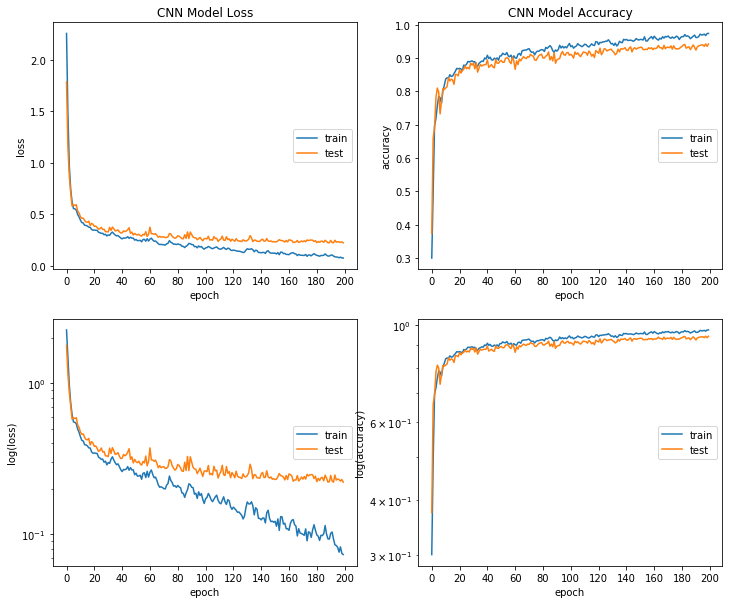

In [26]:
plot_loss_history(CNNmodel0)

In [27]:
cnn0 = CNN_Model(cube_std0_3d.shape[2])
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel0 = cnn0.fit({"spectra":cube_train02}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02}, cube_test_labels0),
                     epochs=60, batch_size=512)

Epoch 1/60
6/6 [==============================] - 1s 171ms/step - loss: 2.2523 - accuracy: 0.3281 - val_loss: 1.5963 - val_accuracy: 0.5218
Epoch 2/60
6/6 [==============================] - 1s 151ms/step - loss: 1.3006 - accuracy: 0.5974 - val_loss: 1.0193 - val_accuracy: 0.6779
Epoch 3/60
6/6 [==============================] - 1s 173ms/step - loss: 0.9062 - accuracy: 0.6769 - val_loss: 0.8200 - val_accuracy: 0.7159
Epoch 4/60
6/6 [==============================] - 1s 157ms/step - loss: 0.7442 - accuracy: 0.7050 - val_loss: 0.7761 - val_accuracy: 0.6639
Epoch 5/60
6/6 [==============================] - 1s 155ms/step - loss: 0.6779 - accuracy: 0.7384 - val_loss: 0.6101 - val_accuracy: 0.7637
Epoch 6/60
6/6 [==============================] - 1s 149ms/step - loss: 0.5800 - accuracy: 0.7693 - val_loss: 0.6062 - val_accuracy: 0.7665
Epoch 7/60
6/6 [==============================] - 1s 159ms/step - loss: 0.5524 - accuracy: 0.7802 - val_loss: 0.5530 - val_accuracy: 0.7806
Epoch 8/60
6/6 [====

In [28]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn0.evaluate({"spectra":cube_train02}, cube_train_labels0)
test_loss, test_acc = cnn0.evaluate({"spectra":cube_test02}, cube_test_labels0)

print(train_acc, test_acc)

23/23 [==============================] - 0s 7ms/step - loss: 0.2871 - accuracy: 0.8973
0.9345991611480713 0.897327721118927


### Predict pixel classification on veg_00000

In [29]:
cube_standard0_1 = cube_standard0.reshape(cube_standard0.shape[0], cube_standard0.shape[1], 1)
print(cube_standard0_1.shape)

(2560000, 848, 1)


In [30]:
# classify entire binned cube
import time
start_time = time.time()

probCube0 = cnn0.predict({"spectra":cube_standard0_1})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:38


In [31]:
predictCube0 = probCube0.argmax(axis=-1)

In [32]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

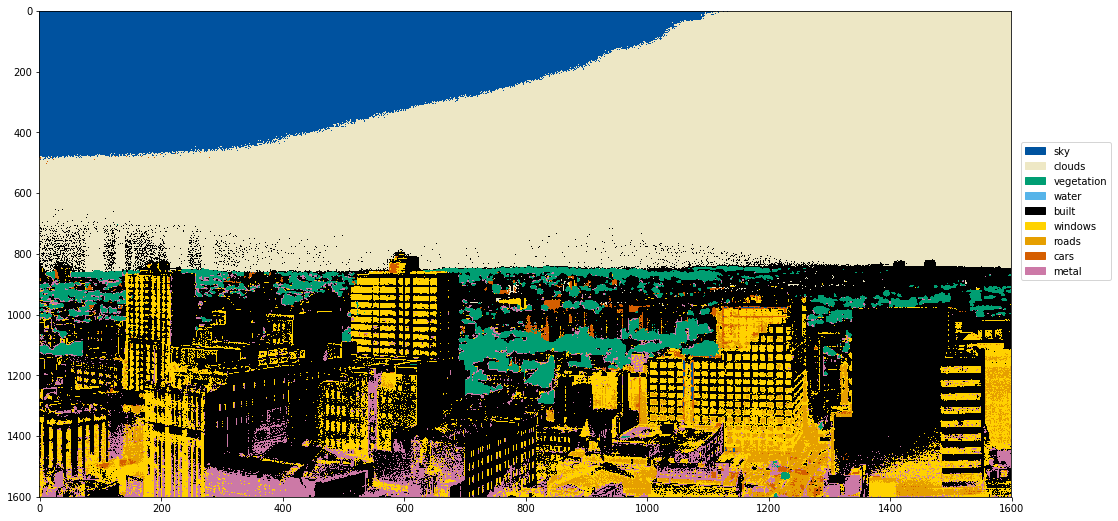

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_3_000_predict_map.png", 
#bbox_extra_artists=(lgd,), bbox_inches='tight')

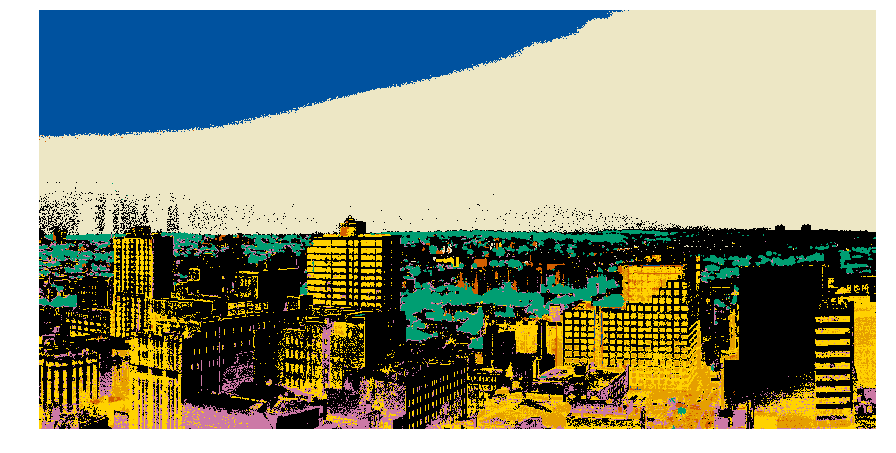

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_no_spatial_train_000_test_000_predict_map.png", bbox_inches='tight', dpi=300)

In [35]:
import pickle
pickle.dump(predictCube_reshape0, open("./plots/CNN_Model2_no_spatial_train_000_test_000_predict_map.pickle", "wb"))

In [36]:
wtr_coords0=np.array([[0,0]])

### Evaluation Metrics (veg_00000)

In [37]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:],1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[veg_test_ind0[:],0], veg_coords0[veg_test_ind0[:],1]]
#labels0_pred_wtr = predictCube_reshape0[wtr_coords0[wtr_test_ind0[:],0], wtr_coords0[wtr_test_ind0[:],1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[blt_test_ind0[:],0], blt_coords0[blt_test_ind0[:],1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[windows_test_ind0[:],0], windows_coords0[windows_test_ind0[:],1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[rds_test_ind0[:],0], rds_coords0[rds_test_ind0[:],1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[cars_test_ind0[:],0], cars_coords0[cars_test_ind0[:],1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[mtl_test_ind0[:],0], mtl_coords0[mtl_test_ind0[:],1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, #labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, 
                               labels0_pred_cars, labels0_pred_mtl))

In [38]:
labels0_true_sky = np.full(len(sky_test_ind0), 0)
labels0_true_clouds = np.full(len(clouds_test_ind0), 1)
labels0_true_veg = np.full(len(veg_test_ind0), 2)
#labels0_true_wtr = np.full(len(wtr_test_ind0), 3)
labels0_true_blt = np.full(len(blt_test_ind0), 4)
labels0_true_windows = np.full(len(windows_test_ind0), 5)
labels0_true_rds = np.full(len(rds_test_ind0), 6)
labels0_true_cars = np.full(len(cars_test_ind0), 7)
labels0_true_mtl = np.full(len(mtl_test_ind0), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, #labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [39]:
print(labels0_pred.shape)
print(labels0_true.shape)

(711,)
(711,)


In [40]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

Confusion Matrix
[[ 80   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0]
 [  0   0 119   3   0   0   0   0]
 [  0   0   0 227   6   0   0   7]
 [  0   0   0  23  66   1   1   9]
 [  0   0   0   0   0  12   0   0]
 [  0   0   0   0   0   4   7   0]
 [  0   0   0  18   0   0   1  27]]

Accuracy Score
0.8973277074542897

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        80
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.98      0.99       122
      built       0.84      0.95      0.89       240
    windows       0.92      0.66      0.77       100
      roads       0.71      1.00      0.83        12
       cars       0.78      0.64      0.70        11
      metal       0.63      0.59      0.61        46

avg / total       0.90      0.90      0.89       711



In [41]:
f = open("./metrics/CNN_Model2_no_spatial_train_000_test_000_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

---
## CNN trained on North Facing Image

In [42]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [43]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [44]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


In [ ]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

In [45]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
print(cube_standard_north.shape)

(1995200, 872)


#### Reading manually classified set for training and testing

In [17]:
sky_coordsn = read_labelled_coordinates("1_sky", "north")
clouds_coordsn = read_labelled_coordinates("2_clouds", "north")
veg_coordsn = read_labelled_coordinates("3_vegetation", "north")
wtr_coordsn = read_labelled_coordinates("4_water", "north")
blt_coordsn = read_labelled_coordinates("5_buildings", "north")
windows_coordsn = read_labelled_coordinates("6_windows", "north")
rds_coordsn = read_labelled_coordinates("7_roads", "north")
cars_coordsn = read_labelled_coordinates("8_cars", "north")
mtl_coordsn = read_labelled_coordinates("9_metal", "north")

1_sky: (300, 2)
2_clouds: (200, 2)
3_vegetation: (700, 2)
4_water: (620, 2)
5_buildings: (1600, 2)
6_windows: (600, 2)
7_roads: (250, 2)
8_cars: (250, 2)
9_metal: (185, 2)


#### split classified pixels into 80% training and 20% testing sets

In [47]:
trrat = 0.8
sky_train_indn, sky_test_indn = split_train_test_indices(sky_coordsn, 100, trrat, "sky")
clouds_train_indn, clouds_test_indn = split_train_test_indices(clouds_coordsn, 200, trrat, "clouds")
veg_train_indn, veg_test_indn = split_train_test_indices(veg_coordsn, 300, trrat, "veg")
wtr_train_indn, wtr_test_indn = split_train_test_indices(wtr_coordsn, 400, trrat, "wtr")
blt_train_indn, blt_test_indn = split_train_test_indices(blt_coordsn, 500, trrat, "blt")
windows_train_indn, windows_test_indn = split_train_test_indices(windows_coordsn, 600, trrat, "windows")
rds_train_indn, rds_test_indn = split_train_test_indices(rds_coordsn, 700, trrat, "rds")
cars_train_indn, cars_test_indn = split_train_test_indices(cars_coordsn, 800, trrat, "cars")
mtl_train_indn, mtl_test_indn = split_train_test_indices(mtl_coordsn, 900, trrat, "mtl")

sky: 240 60
clouds: 160 40
veg: 560 140
wtr: 496 124
blt: 1280 320
windows: 480 120
rds: 200 50
cars: 200 50
mtl: 148 37


In [48]:
cube_stdn_3d = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
print(cube_stdn_3d.shape)

(1600, 1247, 872)


In [49]:
cube_sky_trainn = cube_stdn_3d[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_stdn_3d[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_stdn_3d[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_stdn_3d[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_stdn_3d[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_stdn_3d[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_stdn_3d[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_stdn_3d[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_stdn_3d[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_stdn_3d[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_stdn_3d[windows_coordsn[windows_train_indn[:],0], windows_coordsn[windows_train_indn[:],1],:]
cube_windows_testn = cube_stdn_3d[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_stdn_3d[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_stdn_3d[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_stdn_3d[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_stdn_3d[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_stdn_3d[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_stdn_3d[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

sky  (240, 872) (60, 872)
clouds  (160, 872) (40, 872)
vegetation  (560, 872) (140, 872)
water  (496, 872) (124, 872)
built  (1280, 872) (320, 872)
windows  (480, 872) (120, 872)
roads  (200, 872) (50, 872)
cars  (200, 872) (50, 872)
metal  (148, 872) (37, 872)


In [50]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn, 
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]

In [51]:
cube_train_labelsn = np.array(cube_train_labelsn)
cube_test_labelsn = np.array(cube_test_labelsn)

print(cube_trainn.shape, cube_train_labelsn.shape)
print(cube_testn.shape, cube_test_labelsn.shape)

(3764, 872) (3764,)
(941, 872) (941,)


#### Train CNN

In [52]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [53]:
#keras.utils.plot_model(cnnn, show_shapes=True)
#cnnn.summary()

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

In [54]:
CNNmodeln = cnnn.fit({"spectra":cube_trainn2}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2}, cube_test_labelsn),
                     epochs=200, batch_size=512)

Epoch 1/200
8/8 [==============================] - 2s 213ms/step - loss: 2.2216 - accuracy: 0.2914 - val_loss: 1.8000 - val_accuracy: 0.3762
Epoch 2/200
8/8 [==============================] - 2s 200ms/step - loss: 1.5355 - accuracy: 0.4710 - val_loss: 1.2845 - val_accuracy: 0.5664
Epoch 3/200
8/8 [==============================] - 1s 175ms/step - loss: 1.2074 - accuracy: 0.5802 - val_loss: 1.1701 - val_accuracy: 0.5962
Epoch 4/200
8/8 [==============================] - 1s 182ms/step - loss: 1.0493 - accuracy: 0.6174 - val_loss: 0.9587 - val_accuracy: 0.6482
Epoch 5/200
8/8 [==============================] - 1s 170ms/step - loss: 0.9280 - accuracy: 0.6799 - val_loss: 0.8580 - val_accuracy: 0.6865
Epoch 6/200
8/8 [==============================] - 1s 164ms/step - loss: 0.8453 - accuracy: 0.7062 - val_loss: 0.8150 - val_accuracy: 0.7237
Epoch 7/200
8/8 [==============================] - 1s 180ms/step - loss: 0.7967 - accuracy: 0.7224 - val_loss: 0.7434 - val_accuracy: 0.7651
Epoch 8/200
8

Epoch 59/200
8/8 [==============================] - 1s 176ms/step - loss: 0.3393 - accuracy: 0.8773 - val_loss: 0.3957 - val_accuracy: 0.8831
Epoch 60/200
8/8 [==============================] - 1s 184ms/step - loss: 0.3302 - accuracy: 0.8860 - val_loss: 0.3909 - val_accuracy: 0.8714
Epoch 61/200
8/8 [==============================] - 2s 193ms/step - loss: 0.3036 - accuracy: 0.8945 - val_loss: 0.4074 - val_accuracy: 0.8629
Epoch 62/200
8/8 [==============================] - 1s 179ms/step - loss: 0.3336 - accuracy: 0.8791 - val_loss: 0.3860 - val_accuracy: 0.8916
Epoch 63/200
8/8 [==============================] - 1s 164ms/step - loss: 0.3088 - accuracy: 0.8948 - val_loss: 0.3618 - val_accuracy: 0.8874
Epoch 64/200
8/8 [==============================] - 1s 180ms/step - loss: 0.3021 - accuracy: 0.8961 - val_loss: 0.3633 - val_accuracy: 0.8842
Epoch 65/200
8/8 [==============================] - 2s 194ms/step - loss: 0.2942 - accuracy: 0.9012 - val_loss: 0.3663 - val_accuracy: 0.8789
Epoch 

8/8 [==============================] - 1s 173ms/step - loss: 0.1276 - accuracy: 0.9530 - val_loss: 0.3529 - val_accuracy: 0.9022
Epoch 174/200
8/8 [==============================] - 1s 163ms/step - loss: 0.1265 - accuracy: 0.9572 - val_loss: 0.3405 - val_accuracy: 0.9107
Epoch 175/200
8/8 [==============================] - 1s 167ms/step - loss: 0.1192 - accuracy: 0.9591 - val_loss: 0.3598 - val_accuracy: 0.9054
Epoch 176/200
8/8 [==============================] - 1s 183ms/step - loss: 0.1228 - accuracy: 0.9570 - val_loss: 0.3718 - val_accuracy: 0.9150
Epoch 177/200
8/8 [==============================] - 1s 185ms/step - loss: 0.1236 - accuracy: 0.9530 - val_loss: 0.3408 - val_accuracy: 0.9150
Epoch 178/200
8/8 [==============================] - 1s 175ms/step - loss: 0.1243 - accuracy: 0.9578 - val_loss: 0.3989 - val_accuracy: 0.8969
Epoch 179/200
8/8 [==============================] - 1s 164ms/step - loss: 0.1192 - accuracy: 0.9594 - val_loss: 0.3444 - val_accuracy: 0.9129
Epoch 180/200

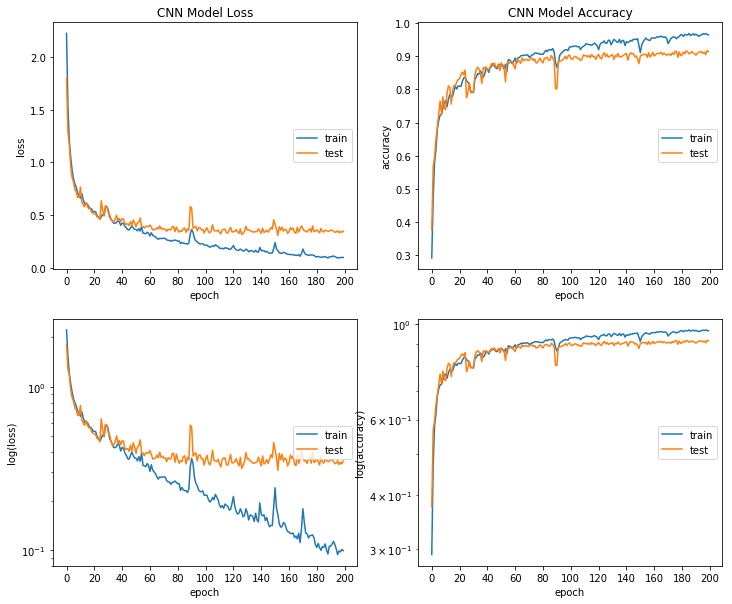

In [55]:
plot_loss_history(CNNmodeln)

In [56]:
cnnn = CNN_Model(cube_stdn_3d.shape[2])
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodeln = cnnn.fit({"spectra":cube_trainn2}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2}, cube_test_labelsn),
                     epochs=60, batch_size=512)

Epoch 1/60
8/8 [==============================] - 2s 191ms/step - loss: 1.8799 - accuracy: 0.3116 - val_loss: 1.4143 - val_accuracy: 0.5547
Epoch 2/60
8/8 [==============================] - 1s 165ms/step - loss: 1.3404 - accuracy: 0.5542 - val_loss: 1.1861 - val_accuracy: 0.6100
Epoch 3/60
8/8 [==============================] - 1s 165ms/step - loss: 1.1015 - accuracy: 0.6073 - val_loss: 1.0193 - val_accuracy: 0.6440
Epoch 4/60
8/8 [==============================] - 1s 173ms/step - loss: 0.9367 - accuracy: 0.6642 - val_loss: 0.9108 - val_accuracy: 0.6908
Epoch 5/60
8/8 [==============================] - 1s 183ms/step - loss: 0.8426 - accuracy: 0.6918 - val_loss: 0.7733 - val_accuracy: 0.7566
Epoch 6/60
8/8 [==============================] - 1s 171ms/step - loss: 0.7517 - accuracy: 0.7410 - val_loss: 0.7311 - val_accuracy: 0.7535
Epoch 7/60
8/8 [==============================] - 1s 164ms/step - loss: 0.7114 - accuracy: 0.7524 - val_loss: 0.6870 - val_accuracy: 0.7726
Epoch 8/60
8/8 [====

In [57]:
# model accuracy on training and testing sets

train_loss, train_acc = cnnn.evaluate({"spectra":cube_trainn2}, cube_train_labelsn)
test_loss, test_acc = cnnn.evaluate({"spectra":cube_testn2}, cube_test_labelsn)

print(train_acc, test_acc)

30/30 [==============================] - 0s 7ms/step - loss: 0.4742 - accuracy: 0.8735
0.9040914177894592 0.8735387921333313


### Predict pixel classification on north facing image

In [58]:
cube_standardn_1 = cube_standard_north.reshape(cube_standard_north.shape[0], cube_standard_north.shape[1], 1)
print(cube_standardn_1.shape)

(1995200, 872, 1)


In [59]:
# classify entire binned cube
import time
start_time = time.time()

probCuben = cnnn.predict({"spectra":cube_standardn_1})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:06:30


In [60]:
predictCuben = probCuben.argmax(axis=-1)

In [61]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

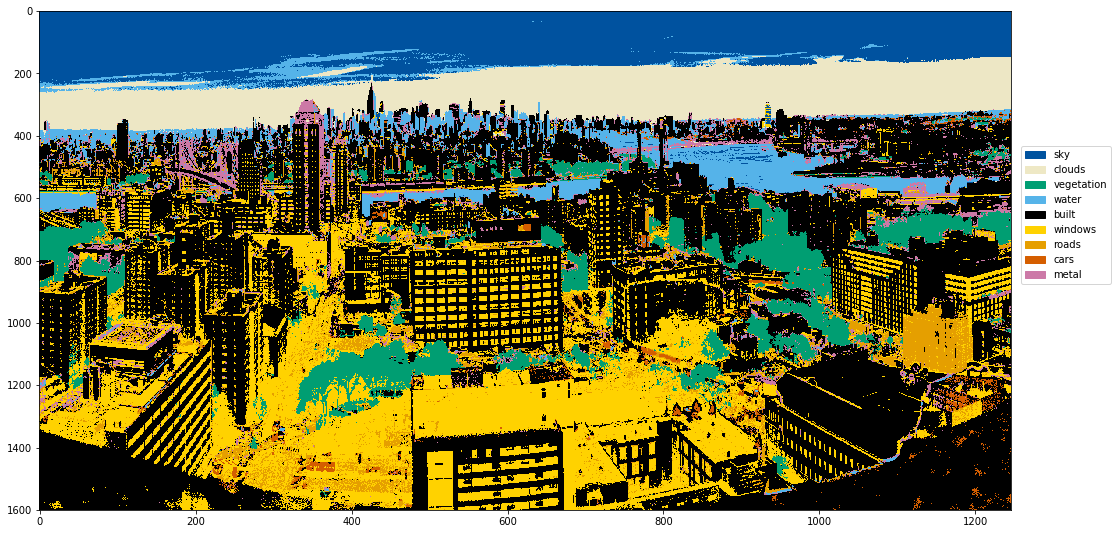

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_5_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

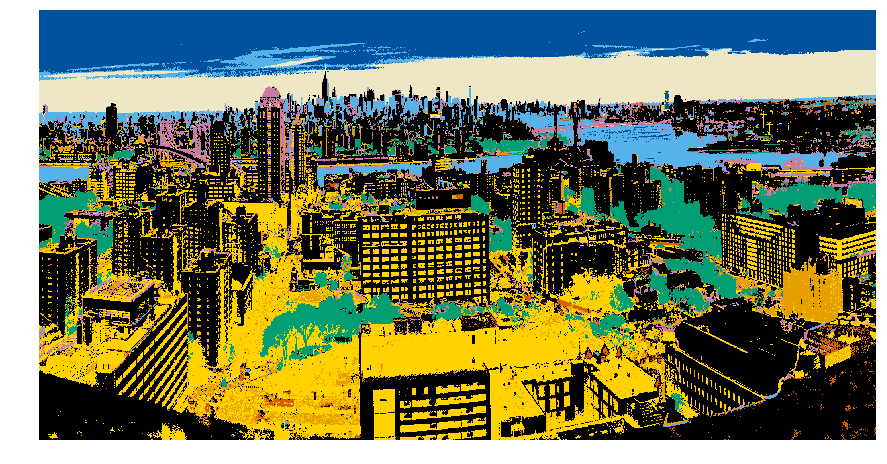

In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_no_spatial_train_north_test_north_predict_map.png", bbox_inches='tight', dpi=300)

In [64]:
import pickle
pickle.dump(predictCube_reshapen, open("./plots/CNN_Model2_no_spatial_train_north_test_north_predict_map.pickle", "wb"))

### Evaluation Metrics (north facing)

In [65]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:],1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[veg_test_indn[:],0], veg_coordsn[veg_test_indn[:],1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[wtr_test_indn[:],0], wtr_coordsn[wtr_test_indn[:],1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[blt_test_indn[:],0], blt_coordsn[blt_test_indn[:],1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[windows_test_indn[:],0], windows_coordsn[windows_test_indn[:],1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[rds_test_indn[:],0], rds_coordsn[rds_test_indn[:],1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[cars_test_indn[:],0], cars_coordsn[cars_test_indn[:],1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[mtl_test_indn[:],0], mtl_coordsn[mtl_test_indn[:],1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [66]:
labelsn_true_sky = np.full(len(sky_test_indn), 0)
labelsn_true_clouds = np.full(len(clouds_test_indn), 1)
labelsn_true_veg = np.full(len(veg_test_indn), 2)
labelsn_true_wtr = np.full(len(wtr_test_indn), 3)
labelsn_true_blt = np.full(len(blt_test_indn), 4)
labelsn_true_windows = np.full(len(windows_test_indn), 5)
labelsn_true_rds = np.full(len(rds_test_indn), 6)
labelsn_true_cars = np.full(len(cars_test_indn), 7)
labelsn_true_mtl = np.full(len(mtl_test_indn), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [67]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(941,)
(941,)


In [68]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0  40   0   0   0   0   0   0   0]
 [  0   0 140   0   0   0   0   0   0]
 [  5   0   0 110   1   0   0   0   8]
 [  0   0   0   1 308  10   0   0   1]
 [  0   0   0   0  12 104   1   0   3]
 [  0   0   1   0   5  20  22   0   2]
 [  0   0   0   0  14  10   1  24   1]
 [  0   0   0   1  12   8   1   1  14]]

Accuracy Score
0.873538788522848

Classification Report
             precision    recall  f1-score   support

        sky       0.92      1.00      0.96        60
     clouds       1.00      1.00      1.00        40
 vegetation       0.99      1.00      1.00       140
      water       0.98      0.89      0.93       124
      built       0.88      0.96      0.92       320
    windows       0.68      0.87      0.76       120
      roads       0.88      0.44      0.59        50
       cars       0.96      0.48      0.64        50
      metal       0.48      0.38      0.42        37

avg / total       0.88      0.87      0.87

In [69]:
f = open("./metrics/CNN_Model2_no_spatial_train_north_test_north_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()

## CNN on veg_00108 (South Facing @ ~2pm)

In [70]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [71]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [72]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [ ]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

In [73]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [74]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


#### split classified pixels into 80% training and 20% testing sets

In [75]:
trrat = 0.8
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 240 60
clouds: 400 100
veg: 480 120
wtr: 40 10
blt: 816 204
windows: 400 100
rds: 24 6
cars: 80 20
mtl: 80 20


In [76]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
print(cube_std_3d.shape)

(1600, 1600, 848)


In [77]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 848) (60, 848)
clouds  (400, 848) (100, 848)
vegetation  (480, 848) (120, 848)
water  (40, 848) (10, 848)
built  (816, 848) (204, 848)
windows  (400, 848) (100, 848)
roads  (24, 848) (6, 848)
cars  (80, 848) (20, 848)
metal  (80, 848) (20, 848)


In [78]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

In [79]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape)
print(cube_test.shape, cube_test_labels.shape)

(2560, 848) (2560,)
(640, 848) (640,)


### Train CNN

In [80]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [81]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [82]:
CNNmodel = cnn.fit({"spectra":cube_train2}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2}, cube_test_labels),
                     epochs=200, batch_size=512)

Epoch 1/200
5/5 [==============================] - 1s 215ms/step - loss: 1.9501 - accuracy: 0.3500 - val_loss: 1.4929 - val_accuracy: 0.4969
Epoch 2/200
5/5 [==============================] - 1s 159ms/step - loss: 1.1887 - accuracy: 0.6449 - val_loss: 0.9068 - val_accuracy: 0.7297
Epoch 3/200
5/5 [==============================] - 1s 174ms/step - loss: 0.8440 - accuracy: 0.7512 - val_loss: 0.7108 - val_accuracy: 0.7781
Epoch 4/200
5/5 [==============================] - 1s 192ms/step - loss: 0.6929 - accuracy: 0.8043 - val_loss: 0.6100 - val_accuracy: 0.8266
Epoch 5/200
5/5 [==============================] - 1s 161ms/step - loss: 0.6095 - accuracy: 0.8090 - val_loss: 0.5199 - val_accuracy: 0.8313
Epoch 6/200
5/5 [==============================] - 1s 169ms/step - loss: 0.5284 - accuracy: 0.8367 - val_loss: 0.4514 - val_accuracy: 0.8766
Epoch 7/200
5/5 [==============================] - 1s 157ms/step - loss: 0.4506 - accuracy: 0.8609 - val_loss: 0.4075 - val_accuracy: 0.8766
Epoch 8/200
5

Epoch 59/200
5/5 [==============================] - 1s 156ms/step - loss: 0.1301 - accuracy: 0.9547 - val_loss: 0.1487 - val_accuracy: 0.9438
Epoch 60/200
5/5 [==============================] - 1s 163ms/step - loss: 0.1337 - accuracy: 0.9570 - val_loss: 0.1499 - val_accuracy: 0.9469
Epoch 61/200
5/5 [==============================] - 1s 160ms/step - loss: 0.1351 - accuracy: 0.9527 - val_loss: 0.1744 - val_accuracy: 0.9453
Epoch 62/200
5/5 [==============================] - 1s 169ms/step - loss: 0.1569 - accuracy: 0.9500 - val_loss: 0.1646 - val_accuracy: 0.9484
Epoch 63/200
5/5 [==============================] - 1s 154ms/step - loss: 0.1486 - accuracy: 0.9457 - val_loss: 0.1452 - val_accuracy: 0.9469
Epoch 64/200
5/5 [==============================] - 1s 159ms/step - loss: 0.1369 - accuracy: 0.9520 - val_loss: 0.1447 - val_accuracy: 0.9484
Epoch 65/200
5/5 [==============================] - 1s 169ms/step - loss: 0.1291 - accuracy: 0.9551 - val_loss: 0.1397 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 1s 153ms/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 0.0870 - val_accuracy: 0.9703
Epoch 174/200
5/5 [==============================] - 1s 145ms/step - loss: 0.0532 - accuracy: 0.9828 - val_loss: 0.1047 - val_accuracy: 0.9688
Epoch 175/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0632 - accuracy: 0.9754 - val_loss: 0.0818 - val_accuracy: 0.9703
Epoch 176/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0545 - accuracy: 0.9805 - val_loss: 0.0901 - val_accuracy: 0.9703
Epoch 177/200
5/5 [==============================] - 1s 149ms/step - loss: 0.0564 - accuracy: 0.9824 - val_loss: 0.0820 - val_accuracy: 0.9688
Epoch 178/200
5/5 [==============================] - 1s 158ms/step - loss: 0.0548 - accuracy: 0.9805 - val_loss: 0.0870 - val_accuracy: 0.9734
Epoch 179/200
5/5 [==============================] - 1s 143ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 0.0840 - val_accuracy: 0.9766
Epoch 180/200

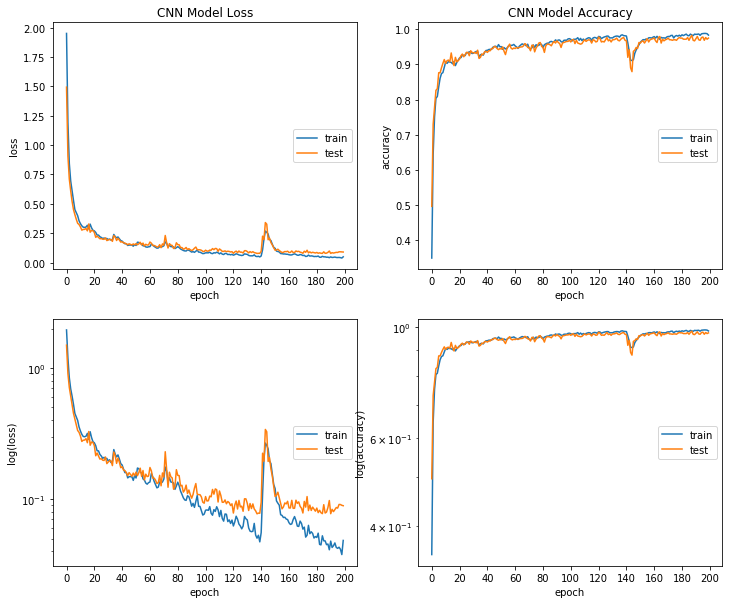

In [83]:
plot_loss_history(CNNmodel)

In [84]:
cnn = CNN_Model(cube_std_3d.shape[2])
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2}, cube_test_labels),
                     epochs=80, batch_size=512)

Epoch 1/80
5/5 [==============================] - 1s 201ms/step - loss: 1.8303 - accuracy: 0.3832 - val_loss: 1.3328 - val_accuracy: 0.7375
Epoch 2/80
5/5 [==============================] - 1s 172ms/step - loss: 1.0986 - accuracy: 0.7031 - val_loss: 0.8355 - val_accuracy: 0.8328
Epoch 3/80
5/5 [==============================] - 1s 167ms/step - loss: 0.7792 - accuracy: 0.7703 - val_loss: 0.6639 - val_accuracy: 0.8219
Epoch 4/80
5/5 [==============================] - 1s 168ms/step - loss: 0.6313 - accuracy: 0.8164 - val_loss: 0.5140 - val_accuracy: 0.8328
Epoch 5/80
5/5 [==============================] - 1s 157ms/step - loss: 0.5064 - accuracy: 0.8547 - val_loss: 0.4174 - val_accuracy: 0.8828
Epoch 6/80
5/5 [==============================] - 1s 172ms/step - loss: 0.4481 - accuracy: 0.8586 - val_loss: 0.4918 - val_accuracy: 0.8453
Epoch 7/80
5/5 [==============================] - 1s 157ms/step - loss: 0.4486 - accuracy: 0.8637 - val_loss: 0.3556 - val_accuracy: 0.8953
Epoch 8/80
5/5 [====

In [85]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn.evaluate({"spectra":cube_train2}, cube_train_labels)
test_loss, test_acc = cnn.evaluate({"spectra":cube_test2}, cube_test_labels)

print(train_acc, test_acc)

20/20 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 0.9422
0.9546874761581421 0.942187488079071


### Predict pixel classification on veg_00108

In [86]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)

(2560000, 848, 1)


In [87]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:14


In [88]:
predictCube = probCube.argmax(axis=-1)

In [89]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

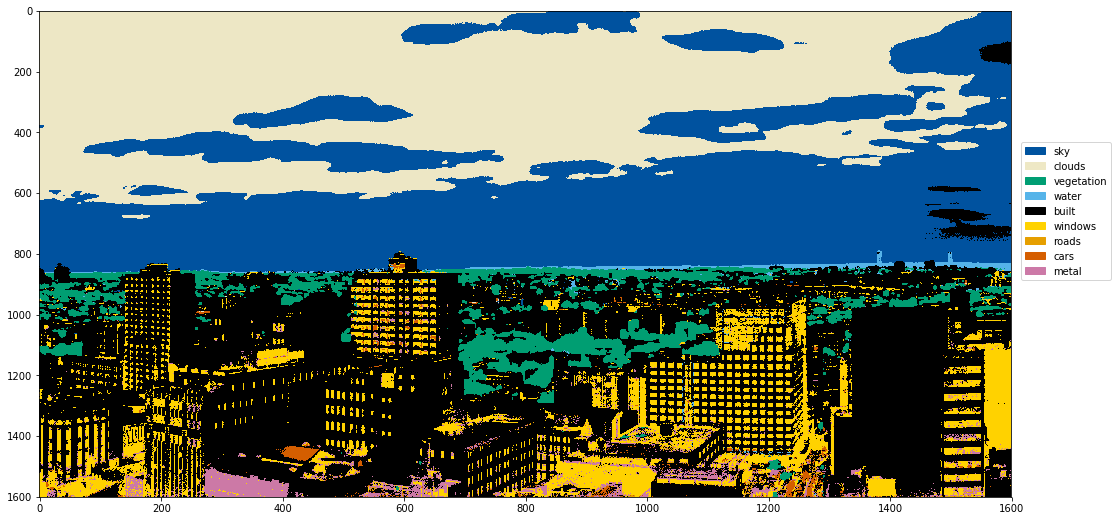

In [90]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

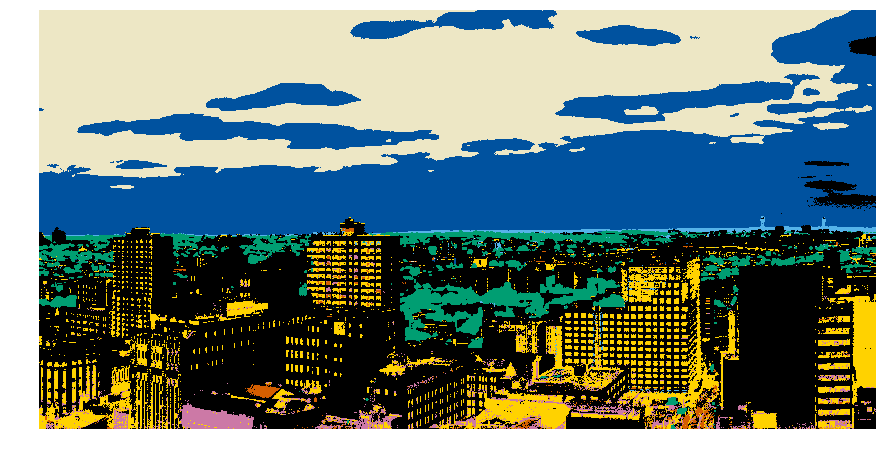

In [91]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_no_spatial_train_108_test_108_predict_map.png", bbox_inches='tight')

In [92]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/CNN_Model2_no_spatial_train_108_test_108_predict_map.pickle", "wb"))

### Evaluation Metrics (veg_00108)

In [93]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [94]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [95]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [96]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 59   1   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 198   3   0   1   2]
 [  0   0   0   0   5  94   0   1   0]
 [  0   0   0   0   3   0   3   0   0]
 [  0   0   0   0   3   4   0  12   1]
 [  0   0   0   0  11   0   0   0   9]]

Accuracy Score
0.9421875

Classification Report
             precision    recall  f1-score   support

        sky       1.00      0.98      0.99        60
     clouds       0.99      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.89      0.97      0.93       204
    windows       0.93      0.94      0.94       100
      roads       1.00      0.50      0.67         6
       cars       0.86      0.60      0.71        20
      metal       0.75      0.45      0.56        20

avg / total       0.94      0.94      0.94       6

In [97]:
f = open("./metrics/CNN_Model2_no_spatial_train_108_test_108_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

### Transfer to predict on veg_00000

In [98]:
# classify entire binned cube
import time
start_time = time.time()

probCube0 = cnn.predict({"spectra":cube_standard0_1})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:08:27


In [99]:
predictCube0 = probCube0.argmax(axis=-1)

In [100]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

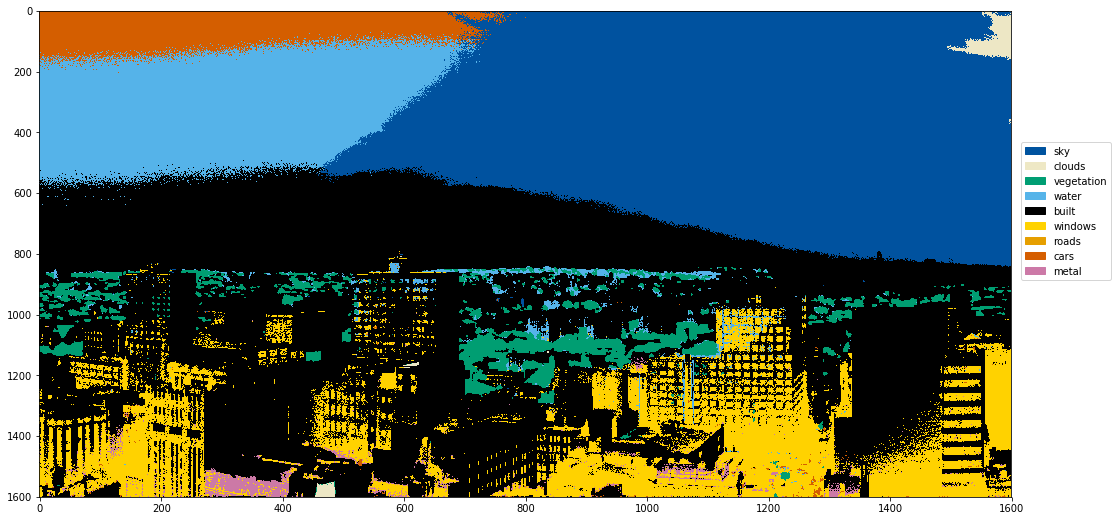

In [101]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_3_000_predict_map.png", 
#bbox_extra_artists=(lgd,), bbox_inches='tight')

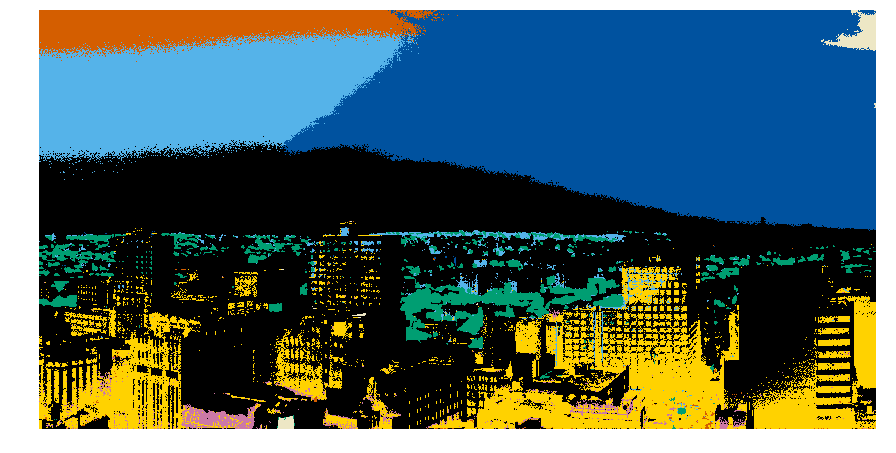

In [102]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_no_spatial_train_108_test_000_predict_map.png", bbox_inches='tight', dpi=300)

In [103]:
import pickle
pickle.dump(predictCube_reshape0, open("./plots/CNN_Model2_no_spatial_train_108_test_000_predict_map.pickle", "wb"))

In [18]:
import pickle
file = open("./plots/CNN_Model2_no_spatial_train_108_test_000_predict_map.pickle", "rb")
predictCube_reshape0 = pickle.load(file)

In [19]:
wtr_coords0=np.array([[0,0]])

### Evaluation Metrics (108 transferred to 000)

In [20]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[:, 0], sky_coords0[:, 1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[:, 0], clouds_coords0[:,1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[:,0], veg_coords0[:,1]]
labels0_pred_wtr = predictCube_reshape0[wtr_coords0[:,0], wtr_coords0[:,1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[:,0], blt_coords0[:,1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[:,0], windows_coords0[:,1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[:,0], rds_coords0[:,1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[:,0], cars_coords0[:,1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[:,0], mtl_coords0[:,1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, 
                               labels0_pred_cars, labels0_pred_mtl))

In [22]:
labels0_true_sky = np.full((sky_coords0.shape[0]), 0)
labels0_true_clouds = np.full((clouds_coords0.shape[0]), 1)
labels0_true_veg = np.full((veg_coords0.shape[0]), 2)
labels0_true_wtr = np.full((wtr_coords0.shape[0]), 3)
labels0_true_blt = np.full((blt_coords0.shape[0]), 4)
labels0_true_windows = np.full((windows_coords0.shape[0]), 5)
labels0_true_rds = np.full((rds_coords0.shape[0]), 6)
labels0_true_cars = np.full((cars_coords0.shape[0]), 7)
labels0_true_mtl = np.full((mtl_coords0.shape[0]), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [23]:
print(labels0_pred.shape)
print(labels0_true.shape)

(3556,)
(3556,)


In [20]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

Confusion Matrix
[[   1    0    0  130    0    0    0  269    0]
 [ 450    7    0    1   42    0    0    0    0]
 [   0    0  572   27   11    0    0    0    0]
 [   0    0    0    0    0    0    0    1    0]
 [   0    0    7    0 1160   26    0    0    7]
 [   2    0   10   15  239  229    2    1    2]
 [   0    0    0    0    0   60    0    0    0]
 [   0    0    0    9    0   18    0   28    0]
 [   0    0    0    0  158   21    0    0   51]]

Accuracy Score
0.5759280089988752

Classification Report
             precision    recall  f1-score   support

        sky       0.00      0.00      0.00       400
     clouds       1.00      0.01      0.03       500
 vegetation       0.97      0.94      0.95       610
      water       0.00      0.00      0.00         1
      built       0.72      0.97      0.83      1200
    windows       0.65      0.46      0.54       500
      roads       0.00      0.00      0.00        60
       cars       0.09      0.51      0.16        55
      metal   

In [21]:
f = open("./metrics/CNN_Model2_no_spatial_train_108_test_000_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 8
  .format(len(labels), len(target_names))


### Transfer to predict on North facing

#### extrapolate north to fit same nwaves as 108

In [114]:
from scipy.interpolate import interp1d

interp_hsi = interp1d(cube_north.waves, cube_standard_north, axis=1, fill_value="extrapolate")
northri = interp_hsi(cube.waves)

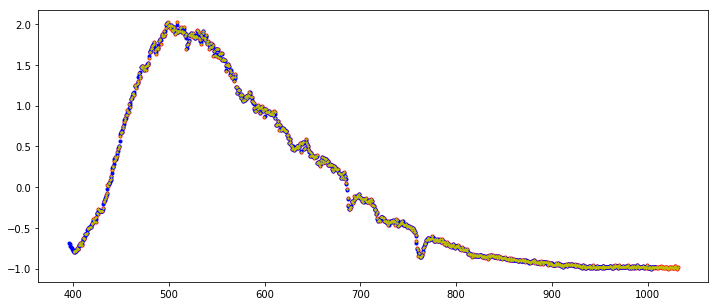

In [115]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cube_north.waves, cube_standard_north[1000, :], ".", color="r")
ax.plot(cube.waves, northri[1000, :], 'o', ms=3, color="b")
ax.plot(cube_north.waves, cube_standard_north[1000, :], ".", ms=3, color="y")

In [118]:
print(northri.shape)
northri_1 = northri.reshape(northri.shape[0], northri.shape[1], 1)
print(northri_1.shape)

(1995200, 848)
(1995200, 848, 1)


In [119]:
# classify entire binned cube
import time
start_time = time.time()

probCuben = cnn.predict({"spectra":northri_1})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:07:01


In [120]:
predictCuben = probCuben.argmax(axis=-1)

In [121]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

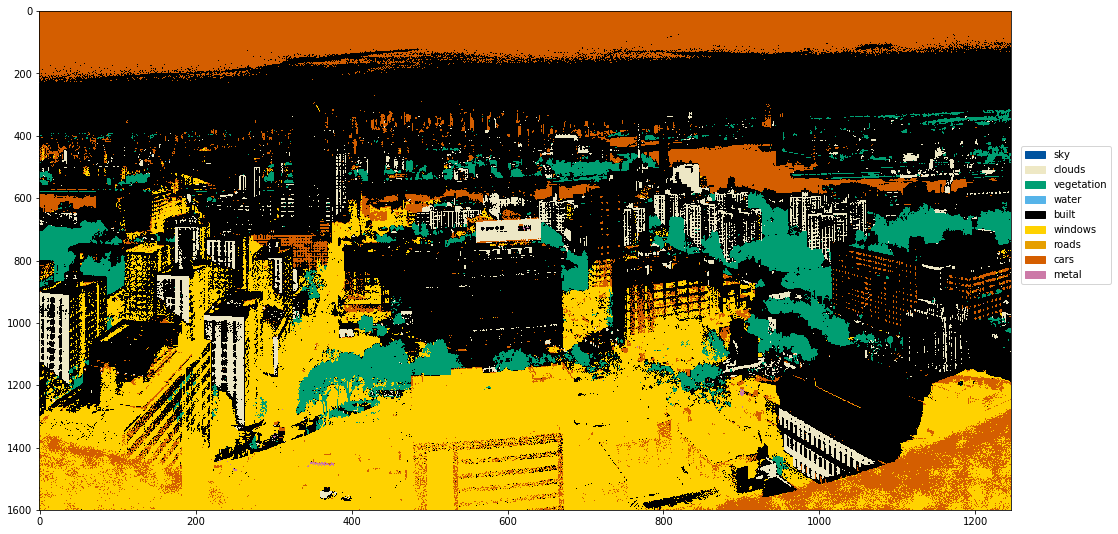

In [122]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_5_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

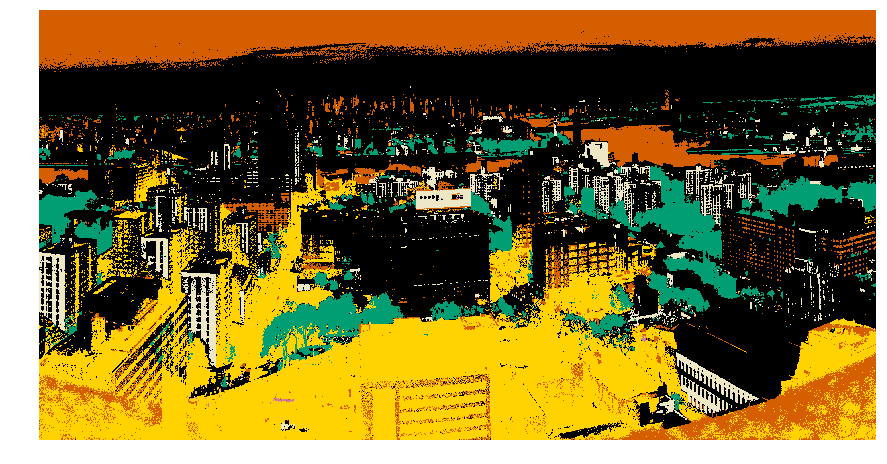

In [123]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_no_spatial_train_108_test_north_predict_map.png", bbox_inches='tight', dpi=300)

In [124]:
import pickle
pickle.dump(predictCube_reshapen, open("./plots/CNN_Model2_no_spatial_train_108_test_north_predict_map.pickle", "wb"))

In [26]:
import pickle
file = open("./plots/CNN_Model2_no_spatial_train_108_test_north_predict_map.pickle", "rb")
predictCube_reshapen = pickle.load(file)

### Evaluation Metrics (108 transferred to North)

In [27]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[:, 0], sky_coordsn[:, 1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[:, 0], clouds_coordsn[:,1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[:,0], veg_coordsn[:,1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[:,0], wtr_coordsn[:,1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[:,0], blt_coordsn[:,1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[:,0], windows_coordsn[:,1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[:,0], rds_coordsn[:,1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[:,0], cars_coordsn[:,1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[:,0], mtl_coordsn[:,1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [28]:
labelsn_true_sky = np.full((sky_coordsn.shape[0]), 0)
labelsn_true_clouds = np.full((clouds_coordsn.shape[0]), 1)
labelsn_true_veg = np.full((veg_coordsn.shape[0]), 2)
labelsn_true_wtr = np.full((wtr_coordsn.shape[0]), 3)
labelsn_true_blt = np.full((blt_coordsn.shape[0]), 4)
labelsn_true_windows = np.full((windows_coordsn.shape[0]), 5)
labelsn_true_rds = np.full((rds_coordsn.shape[0]), 6)
labelsn_true_cars = np.full((cars_coordsn.shape[0]), 7)
labelsn_true_mtl = np.full((mtl_coordsn.shape[0]), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [29]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(4705,)
(4705,)


In [30]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

Confusion Matrix
[[  0   0   0   0   0   0   0 300   0]
 [  0   0   0   0 200   0   0   0   0]
 [  0   0 698   0   0   2   0   0   0]
 [  0   0   2   0 167   0   0 451   0]
 [  0 259   0   0 780 353   0 208   0]
 [  0   1   8   0 334 250   0   7   0]
 [  0   1   2   0  72 175   0   0   0]
 [  0   3   1   0 105  81   0  40  20]
 [  0   1   1   0 166  17   0   0   0]]

Accuracy Score
0.3757704569606801

Classification Report
             precision    recall  f1-score   support

        sky       0.00      0.00      0.00       300
     clouds       0.00      0.00      0.00       200
 vegetation       0.98      1.00      0.99       700
      water       0.00      0.00      0.00       620
      built       0.43      0.49      0.46      1600
    windows       0.28      0.42      0.34       600
      roads       0.00      0.00      0.00       250
       cars       0.04      0.16      0.06       250
      metal       0.00      0.00      0.00       185

avg / total       0.33      0.38      0.3

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
f = open("./metrics/CNN_Model2_no_spatial_train_108_test_north_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
